# ENGG03 - Avaliação 03

* **Docente:** Raony Maia Fontes
* **Alunos:** Anna Carolina, Breno Conceição, Gustavo Santos Borges, Maurício Vicente

# Avaliação 3
Considere a modelagem da distribuição de temperatura em um dissipador em forma de pino usado para resfriar um objeto. Se convecção e radiação forem incluídas na análise, a temperatura $T(t,x)$ ao longo do dissipador pode ser obtida com a solução de uma equação na forma
\begin{align}
\frac{\partial T(t,x)}{\partial t} &= \beta\frac{d^2T}{dx^2} -k_0 \left(T(t,x) - T_s\right) - k_1 \left(T^4(t,x) - T_s^4\right) \\
\end{align}
onde $k = [1.67, ~9.45\times 10^{-10}]$, $\beta = 1\times 10^{-2}$, $L= 0.5$ são parâmetros do sistema, $T_s=293$K é a temperatura ambiente, $T(t,x)$ é a Temperatura em função do tempo e do comprimento, $x$, da barra.

Dada as seguintes condições de contorno
$\begin{cases}
T(0,x) &= 493.0\\
T(t,0) &= 493.0\\
\frac{\partial T(t,x)}{\partial x}|_{x=L} & = 0
\end{cases}$,
pede-se:
1.   (3,0) Quanto tempo o sistema leva para atingir o estado estacionário?
2.   (5,0) Determine os melhores parâmetros $k$ que resultam em um resfriamento mais rápido para temperatura no final do pino $T(t,L)$, sabendo que:
\begin{align}
&0 \leq k_0 \leq 3.5\\
&0 \leq k_1 \leq 2.0\times 10^{-9}
\end{align}
3. (2,0) Compare os tempos de resfriamentos obtidos



#### Importação de bibliotecas

O primeiro passo para a devida execução do programa é a importação das bibliotecas necessárias para atingir os objetivos propostos. Entre elas, é possível citar:

*   `numpy`: Biblioteca que permite a manipulação de dados em arranjos, vetores, matrizes multi-dimensionais e operações matemáticas;
*   `scipy`: Biblioteca que também permite empregar operações matemáticas ao código, porém, incorpora de forma acessível operadores e métodos mais complexos, tais quais a `solve_ivp`, função utilizada para resolução de equações diferenciais, e a `minimize`, função com a qual é possível minimizar funções escalares para ordens menores;
*   `matplotlib`: Biblioteca utilizada para plotagem de gráficos ilustrando os dados e resultados de processamentos feitos no programa.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

#### Definição de constantes

Em seguida, as constantes do sistema fornecidas no enunciado serão definidas no programa, para que sejam inseridas em seus respectivos contextos, sendo essas:

*   `L`: Comprimento do dissipador ($L$)
*   `beta`: Coeficiente de troca térmica ($\beta$)
*   `k`: Array contendo os coeficientes de condutividade ($k$, ou, respectivamente, $k_{0}$ e $k_{1}$)
*   `T_s`: Temperatura ambiente ($T_{s}$)

In [ ]:
L = 0.5
beta = 1*(10**-2)
k = [1.67, 9.45e-10]
T_s = 293.0

De acordo com o enunciado, uma das etapas da atividade proposta é encontrar os melhores parâmetros $k_{1}$ e $k_{2}$ que resultam em um resfriamento mais rápido para a temperatura no final do pino, sabendo que $0 \leq k_0 \leq 3.5$ e $0 \leq k_1 \leq 2.0\times 10^{-9}$. Logo, os limites desses intervalos serão declarados em código, sendo:

*   `Limites`: Array contendo os valores máximo e mínimo de cada intervalo - a primeira posição sendo o intervalo referente aos valores possíveis de $k_{0}$ e a segunda o intervalo de valores possíveis de $k_{1}$
*   `LimInf`: Os valores mínimos que $k_{0}$ e $k_{1}$ podem assumir
*   `LimSup`: Os valores máximos que $k_{0}$ e $k_{1}$ podem assumir

In [ ]:
Limites = [(0, 3.5), (0, 2*(10**-9))]

LimInf = [0, 0]
LimSup = [3.5, 2*(10**-9)]

#### Definição das condições de simulação

Nesta etapa, serão estabelecidas algumas condições sob as quais a simulação será feita:

*   `n_x`: Número de pontos discretos ao longo do comprimento $x$ da barra
*   `n_t`: Número de pontos discretos ao longo do intervalo de análise $t$ - vale destacar que, quanto maior o número de divisões ao longo do tempo, maior será a precisão
*   `tf`: Momento final da simulação

In [ ]:
n_x = 51
n_t = 50
tf = 8

Tendo o comprimento da barra, como dado no enunciado, e definida a quantidade de pontos discretos ao longo do dito comprimento, é possível criar uma array `x` que contém essas subdivisões em unidade de comprimento:

In [ ]:
x = np.linspace(0, L, n_x)

Dessa forma, é possível também estabelecer um diferencial - Δ - do comprimento (`dx`), com o qual, futuramente, será possível resolver a segunda derivada:

In [ ]:
dx = x[1] - x[0]

Enfim, tendo a quantidade de pontos discretos na qual o intervalo de análise $t$ será dividido, tendo estabelecido que a análise partirá de um tempo inicial igual a $0$ e conhecendo o momento final da simulação, é possivel criar uma array $t$ com as subdivisões em unidade de tempo:

In [ ]:
t = np.linspace(0, tf, n_t)

E por último, dadas aqs condições iniciais, será criada uma array `T0` na qual serão armazenados os valores de temperatura inicial ao longo do comprimento da barra:

In [ ]:
T0 = np.zeros(n_x)
T0[0:-1] = 493.0
T0[-1] = 493.0

Importante destacar que ao fazer uma discretização com mais pontos pode levar a ter um resultado mais preciso. Já que iremos ter uma diferença cada vez menor entre os pontos da barra e os pontos do tempo. Sendo assim, esse é um dos fatores que pode levar a uma diferença de resultados.

#### Atingimento do estado estacionário

O primeiro item solicitado no enunciado diz respeito à definição do tempo necessário para que o sistema atinja o estado estacionário. Essa estipulação será viabilizada, primeiramente, pela definição de uma função que descreva, programaticamente, a derivada da temperatura em função do tempo - $\frac{\partial T(t,x)}{\partial t}$ - sendo esta a função `edp_dTdt`, a qual receberá como parâmetros:

*   `t`: Momento no qual a simulação está sendo realizada
*   `T`: Array contendo as temperaturas da barra ao longo do seu comprimento
*   `k0` e `k1`: Coeficientes de condutividade térmica

Durante o laço de repetição no qual é feito o cálculo das derivadas ponto a ponto, são considerados os pontos inicial e final, equivalentes às extremidades da barra, respeitando o que o enunciado diz a respeito das condições de contorno.

Por último, a função retorna uma array - `dTdt` - contendo os valores da derivada ponto a ponto ao longo do comprimento da barra:

In [ ]:
def edp_dTdt(t,T, k0, k1):
  T_s = 293.0
  dTdt = np.zeros(n_x)
  for i in range(n_x):
    if i == 0:
      dTdt[i] = 0
    elif i == n_x-1:
      dTdt[i] = 0 - k0*(T[i] - T_s) - k1*(T[i]**4 - T_s**4)
    else:
      dTdt[i] = beta*(T[i-1] - 2*T[i] + T[i+1])/(dx**2) - k0*(T[i] - T_s) - k1*(T[i]**4 - T_s**4)
  return dTdt

Definida a função que descreve o comportamento da expressão fornecida no enunciado, é possível utilizar a `solve_ivp` para resolução da equação diferencial, com o resultado sendo armazenado na variável `sol`. Importante destacar que, ao longo do código, foi preferido o uso do método LSODA para resolução das equações diferenciais, objetivando maior velocidade e menor processamento em relação À RK45:

In [ ]:
sol = solve_ivp(edp_dTdt, [0, tf], T0, args= (k[0],k[1]), t_eval=t, method="LSODA", rtol=1e-8, atol=1e-8)

O momento em que o sistema atinge o estado estacionário pode ser definido como o momento em que a variação tangencia zero.

Para tal, foi definido um valor de tolerância equivalente a $1\times 10^{-4}$ - armazenado em `tol` - e feita, ponto a ponto ao longo do intervalo de simulação, a diferença entre o ponto analisado e o seu anterior. No momento em que essa diferença for menor que o valor de tolerância, considera-se este como o ponto de início do estado estacionário. É importante lembrar que quanto menor for essa tolerância, mais preciso serão os valores encontrados.

Além disso, é possível determinar que a partir de um dado momento, o estado irá se tornar estacionário e continuará dessa forma, por causa do gráfico que ela forma, como é um resfriamento, ele tende a ter a representação de uma função exponencial com expoente negativo, sendo assim, começa com uma curva e tende a uma reta, fazendo com que a variação - a derivada - fique menor a cada instante de tempo.

Essa rotina foi descrita na função `estacionario`, que recebe como parâmetro `solucao`, este sendo a resolução da equação diferencial obtida atravésda `solve_ivp`:

In [ ]:
def estacionario(solucao):
  tol=1e-4
  for i in range(1, len(solucao.t)):
    variação = solucao.y[:, i] - solucao.y[:, i-1]
    if np.all(np.abs(variação) < tol):
      return solucao.t[i]

Por fim, é possível exibir em terminal o resultado esperado, sendo este o momento em que o sistema atinge o estado estacionário:

In [ ]:
print(estacionario(sol))

7.673469387755102


#### Otimização dos coeficientes de condutividade

O segundo item solicitado no enunciado trata da otimização dos coeficientes de condutividade térmica do sistema simulado, tendo em vista a busca por menores tempos de resfriamento da peça estudada.

A função `otimizar` recebe como parâmetros os valores dos coeficientes de condutividade em forma de array e, repetindo o processo de resolução da equação diferencial da temperatura fornecida no enunciado, retorna o tempo necessário para atingimento do estado estacionário para os coeficientes fornecidos.

Seu uso em conjunto com a função `minimize` objetiva encontrar valores de coeficientes para os quais o tempo de atingimento do estado estacionário é mínimo. São considerados como pontos de partida os valores máximos que $k_{0}$ e $k_{1}$ podem assumir dados os intervalos fornecidos. São também fornecidos os arrays contendo os intervalos dentre os quais esses coeficientes variarão - `LimSup e `Limites`, respectivamente:

In [ ]:
def otimizar(k):
  k0 = k[0]
  k1 = k[1]
  t = np.linspace(0, tf, 50)
  sol = solve_ivp(edp_dTdt, [0, tf], T0, args=(k0,k1), t_eval=t, method="LSODA", rtol=1e-8, atol=1e-8)
  return estacionario(sol)

otimizado = minimize(otimizar, x0=LimSup, bounds=Limites)

Após encontrar a solução otimizada, os valores encontrados são armazenados na variável `K_otimo`, sendo `K_otimo0` e `K_otimo1` os valores de $k_{0}$ e $k_{1}$ encontrados durante a minimização.

In [ ]:
K_otimo = otimizado.x
print(K_otimo) # Print dos valores ótimos de k0 e k1
K_otimo0 = K_otimo[0] # Divisão dos valores ótimos de k0
K_otimo1 = K_otimo[1] # Divisão dos valores ótimos de k0

[3.5e+00 2.0e-09]


Dado o cenário, é plausível que os valores otimizados sejam os maiores possíveis, dado que, quanto maior os coeficientes de condutividade térmica, maior será a troca de calor com o ambiente. Mesmo assim, ao testar diversos valores entre os limites estabelecidos pelo enunciado, obtives 3 valores diferentes, sendo eles: O limite inferior, o limite superior e os valores dados no enunciado. Sendo assim, o primeiro não tem sentido físico, pois ao utilizá-los iriamos ter a inexistência da convecção e da radiação; O segundo nós já utilizamos, sendo assim um mínimo local em uma região grande; E o terceiro que acaba fazendo mais sentido físico.

Pois, partindo de um estado inicial no qual a temperatura da peça é maior que a temperatura ambiente, a troca caracterizará um resfriamento. Sendo os coeficientes ótimos, estes serão máximos.

Para fins de visualização e validação, será feita novamente a simulação do sistema, utilizando, dessa vez, os coeficientes otimizados:

In [ ]:
sol_otima = solve_ivp(edp_dTdt, [0, tf], T0, args=(K_otimo0, K_otimo1), t_eval=t, method="LSODA", rtol=1e-8, atol=1e-8)
print(estacionario(sol_otima))

3.9183673469387754


Vista a expressiva diminuição no tempo para atingimento do estado estacionário, é possível afirmar que o experimento foi um sucesso.

#### Comparação dos tempos de resfriamento

O último item solicitado no enunciado diz respeito à comparação dos tempos de resfriamento no final da peça, levando em conta os coeficientes de condutividade originais e os coeficientes otimizados.

Na função `esfriou` proposta, define-se como o ponto esperado de resfriamento o momento no qual a extremidade da peça atingiu a temperatura ambiente. Para obter o momento no qual essa meta é atingida, é feita uma comparação ponto a ponto ao longo do intervalo de simulação e, caso a diferença entre a temperatura naquele instante e a temperatura ambiente `T_amb` seja menor que o valor de tolerância `Tol` estipulado - dessa vez, de $1\times 10^{-2}$ - é determinado que a peça foi devidamente resfriada:

In [ ]:
def esfriou(sol):
  Tol = 1e-2
  T_amb = 293
  for k in range(0,n_t):
    if sol.y[-1,k] - T_amb < Tol:
      return sol.t[k]

Visto que ambas as soluções foram simuladas anteriormente e armazenadas nas variáveis `sol` e `sol_otima`, essas serão utilizadas como argumentos da função `esfriou`, determinando assim o tempo de resfriamento em ambas as situações:

In [ ]:
print(f"Tempo de resfriamento (coeficientes iniciais): {esfriou(sol)}")
print(f"Tempo de resfriamento (coeficientes otimizados): {esfriou(sol_otima)}")

Tempo de resfriamento (coeficientes iniciais): 5.7142857142857135
Tempo de resfriamento (coeficientes otimizados): 2.7755102040816326


Mais uma vez, nota-se uma diminuição expressiva no tempo para conclusão da troca térmica quando utilizados os coeficientes otimizados, corroborando com a linha de raciocínio descrita anteriormente, na qual o aumento do valores dos coeficientes de condutividade térmica favoreceriam a troca de calor com o ambiente, resfriando a peça em menos da metade do tempo demandado anteriormente.

Graficamente, as variações podem ser visualizadas através dos gráficos abaixo, sendo os dois gráficos de cima as observações do sistema tendo como parâmetros os coeficientes de condutividade originais e os dois gráficos de baixo as observações tendo como parâmetros os coeficientes otimizados:

Text(0, 0.5, 'T(t,x)')

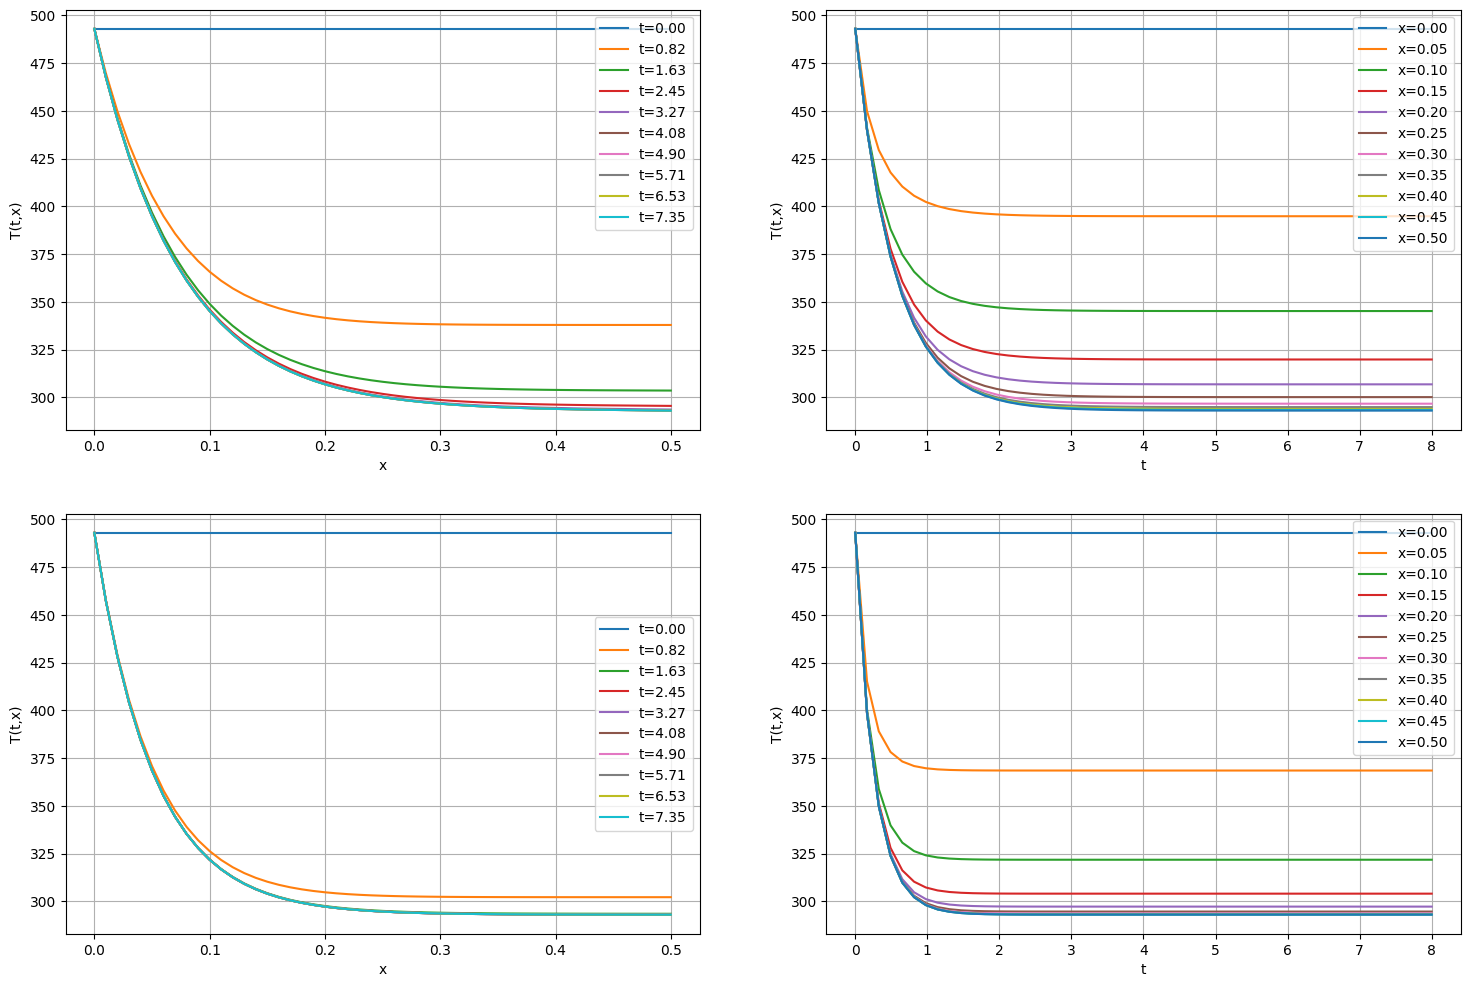

In [ ]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
for k in range(0,n_t,5):
  plt.plot(x,sol.y[:,k],label=f't={t[k]:.2f}')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('T(t,x)')

plt.subplot(2, 2, 2)
for i in range(0,n_x,5):
  plt.plot(sol.t,sol.y[i,:],label=f'x={x[i]:.2f}')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('T(t,x)')

plt.subplot(2, 2, 3)
for i in range(0,n_t,5):
  plt.plot(x,sol_otima.y[:,i],label=f't={t[i]:.2f}')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('T(t,x)')

plt.subplot(2, 2, 4)
for i in range(0,n_x,5):
  plt.plot(sol_otima.t,sol_otima.y[i,:],label=f'x={x[i]:.2f}')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('T(t,x)')

Dentre os efeitos observados a respeito da mudança dos coeficientes de condutividade utilizados, é possível destacar que, ao utilizar coeficientes otimizados, as curvas convergem mais rapidamente a valores estacionários, o que indica que, nessas condições, o sistema entra em equilíbrio térmico mais rapidamente.

Além disso, o fato de - mais uma vez, observando o comportamento do sistema com coeficientes otimizados na entrada - as curvas serem menos dispersas ao longo do tempo e da posição denotam maior uniformidade da temperatura ao longo do comprimento da peça, indicando que, nessas condições, há maior consistência no comportamento térmico do sistema.

O último gráfico observado diz respeito à variação de temperatura na extremidade da peça:

Text(0, 0.5, 'T(t,x)')

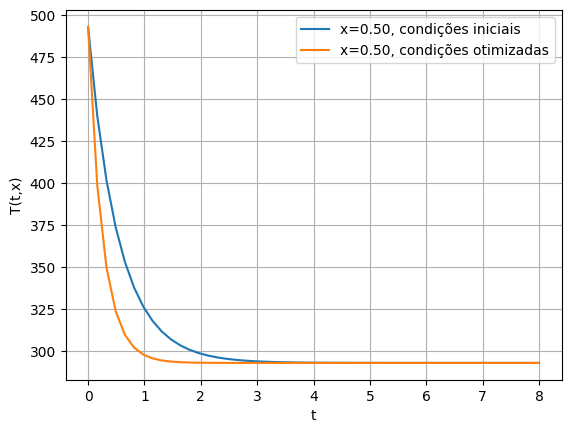

In [ ]:
plt.figure()
plt.plot(sol.t,sol.y[-1,:],label=f'x={x[i]:.2f}, condições iniciais')
plt.plot(sol_otima.t, sol_otima.y[-1,:],label=f'x={x[i]:.2f}, condições otimizadas')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('T(t,x)')

Observa-se que, na extremidade analisada, e tendo como parâmetros de entrada os coeficientes de condutividade otimizados, a curva de temperatura ao longo do tempo se estabiliza consideravelmente antes, consolidando as conclusões feitas anteriormente a respeito do impacto da mudança dos coeficientes no tempo de resfriamento e estabilização do sistema.